# SymNMF numerical experiments

This notebook shows how to reproduce the experiments for Symmetric Nonnegative Matrix Factorization (SymNMF) described in 

> R.A. Dragomir, A. d'Aspremont and J. Bolte. Quartic First-Order Methods for Low Rank Minimization (2019)

In [100]:
include("utils.jl")
include("PG.jl") # projected gradient 
include("BPG.jl") # Bregman proximal gradient algorithms (Nolips and variants)
include("Beta.jl")
include("CD.jl")
include("SymHALS.jl")
include("SymANLS.jl")

include("SymNMF.jl") # wrapper for all SymNMF solvers

SymNMF

In [101]:
using LinearAlgebra
using PyPlot
using Random
using NPZ
using SparseArrays
using JLD

# 1. Defining algorithm-specific parameters

In [102]:
algos = [:pga, :nolips, :acc_nolips, :dyn_nolips, :beta, :cd, :sym_hals]
algo_names = Dict(:pga => "PG", :dyn_nolips => "Dyn-Nolips", 
    :beta => "Beta", :cd => "CD",
    :sym_hals => "SymHALS", :sym_anls => "SymANLS")

algo_params = Dict()

algo_params[:pga] = (step = 1., beta = 0.1, sigma = 0.01, max_inner_iter = 20)
algo_params[:dyn_nolips] = (step = 1., gamma_inc = 2., gamma_dec = 2.)
algo_params[:beta] = (beta = 0.99,)
algo_params[:cd] = ()
algo_params[:sym_hals] = (mu = 1e-2,)

(mu = 0.01,)

# 2. Loading data

All similarity matrices can be found in a pre-processed format in the ```data/``` folder. Choose the dataset by setting the ```dataset``` variable below:

In [103]:
possible_choices = [:synth500, :synth1000, :cbcl, :coil20, :tdt2, :reuters]

dataset = :tdt2 # CHANGE HERE

:tdt2

We now load the desired dataset and set the specific experiment parameters (such as the penalization $\mu$ for penalty methods, and the maximal running time):

In [104]:
max_iter = 12000
max_time = 10.
monit_acc = true;
y_true = [0]

function load_dataset(ds_name)
    file_content = load("data/$ds_name.jld") 
    return file_content["M"], file_content["labels"]
end

if dataset == :synth500 # synthetic dataset
    mu = 1e1
    max_time = 5.
    n, r = 500, 20
    M, r = synthetic_SNMF(n, r), r;
    monit_acc = false

elseif dataset == :synth1000
    mu = 1e1
    max_time = 10.
    n, r = 1000, 30
    M, r = synthetic_SNMF(n, r), r;
    monit_acc = false

elseif dataset == :cbcl
    mu = 1e-2
    max_time = 10.
    r = 20
    M, y_true = load_dataset("cbcl")
    monit_acc = false

elseif dataset == :coil20
    mu = 1e-2
    max_time = 20.
    M, y_true = load_dataset("coil20")
    r = 20

elseif dataset == :tdt2
    mu = 1e-1
    max_time = 20.
    M, y_true = load_dataset("tdt2")
    r = 30
    
elseif dataset == :reuters
    mu = 1e-1
    max_time = 20.
    M, y_true = load_dataset("reuters")
    r = 25

elseif dataset == :orl
    mu = 1e-2
    max_time = 10.
    M, y_true = load_dataset("orl")
    r = 40
end
algo_params[:sym_hals] = (mu = mu,)
algo_params[:sym_anls] = (mu = mu,)

monitoring_interval = max_time / 20.;

# 3. Running experiments

We start by defining a convenient wrapper for running an algorithm:

In [105]:
function run_algo(algo::Symbol, A0::Matrix{Float64}, algo_params)
    SymNMF(M, r; algo = algo, 
        max_iter = max_iter, 
        max_time = max_time,
        monitoring_interval = monitoring_interval, 
        A_init = A0, 
        monitor_accuracy = monit_acc, 
        true_labels = y_true,
        algo_params...);
end;

Run this cell to launch simulations. The variable ```n_runs``` controls the number of random initializations to try.

As an example we launched 5 simulations for the TDT2 dataset.  

In [111]:
n_runs = 5 # number of runs to average

algos_to_run = [:pga, :dyn_nolips, :beta, :cd,
    :sym_hals, :sym_anls]

all_losses = Dict()
clust_accs = Dict()
n_measures = Dict()
min_loss = Inf

for t = 1:n_runs
    println("Run number $t / $n_runs ...")
    A0 = random_init_sym(M, r);

    for algo = algos_to_run
        params, name = algo_params[algo], algo_names[algo]

        A, losses = run_algo(algo, A0, params)
        
        # updating minimal loss
        min_loss = min(min_loss, minimum(losses[:,2]))
        
        if t == 1
            all_losses[algo] = losses
            clust_accs[algo] = [losses[end,:4]]
        else
            push!(clust_accs[algo], losses[end,:4])
            
            # a procedure to ensure that all losses measures have same size,
            # in order to average them
            n_meas_old = size(all_losses[algo],1)
            n_meas_new = min(n_meas_old, size(losses,1))

            trimmed_old_losses = all_losses[algo][1:n_meas_new,:]
            trimmed_losses = losses[1:n_meas_new,:]
            
            all_losses[algo] = ((t - 1) * trimmed_old_losses + trimmed_losses) / t
        end
    end    
end

all_losses[:min_loss] = min_loss

Run number 1 / 5 ...
Terminated after 285 iterations.
Terminated after 255 iterations.
Terminated after 426 iterations.
Terminated after 2 iterations.
Constraint satisfaction for penalty method sym_hals : |A - B|/|A| = 0.001132538169582914
Terminated after 144 iterations.
Constraint satisfaction for penalty method sym_anls : |A - B|/|A| = 0.05145149760599812
Terminated after 7 iterations.
Run number 2 / 5 ...
Terminated after 303 iterations.
Terminated after 286 iterations.
Terminated after 441 iterations.
Terminated after 2 iterations.
Constraint satisfaction for penalty method sym_hals : |A - B|/|A| = 0.0015462060259264186
Terminated after 160 iterations.
Constraint satisfaction for penalty method sym_anls : |A - B|/|A| = 0.03921059181973255
Terminated after 10 iterations.
Run number 3 / 5 ...
Terminated after 320 iterations.
Terminated after 296 iterations.
Terminated after 449 iterations.
Terminated after 2 iterations.
Constraint satisfaction for penalty method sym_hals : |A - B|/|

250.0118889427224

# 4. Plotting the convergence speed

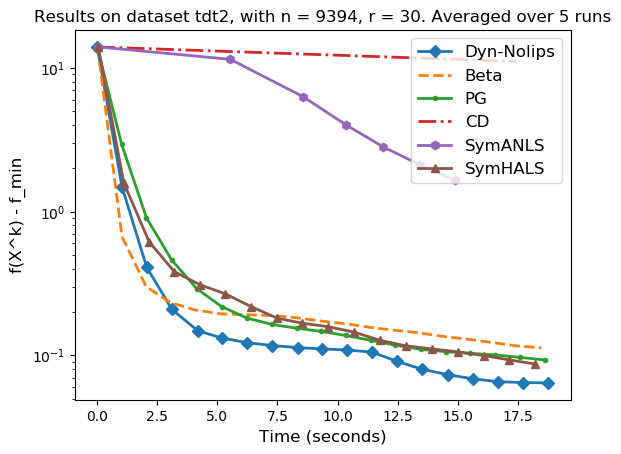

PyObject Text(0.5, 1, 'Results on dataset tdt2, with n = 9394, r = 30. Averaged over 5 runs')

In [114]:
fig, ax = subplots()

markers = Dict(:pga => ".", :nolips => "v", :acc_nolips => "s",
    :dyn_nolips => "D", :cd => "None",
    :sym_hals => "^", :sym_anls => "h", :dyn_acc_nolips => "s", :beta => "None")


algos_to_show = [:dyn_nolips, :beta, :pga, :cd, :sym_anls, :sym_hals]

linestyles = Dict()
for algo = algos_to_show
   linestyles[algo] = "-" 
end

linestyles[:beta] = "--"
linestyles[:cd] = "-."

function plot_loss(axis, losses, label, marker, ls)
    min_loss = all_losses[:min_loss]
    axis.plot(losses[:,1], losses[:,2] .- min_loss, label = label,
        marker = marker, linestyle = ls, linewidth = 2)
end

for algo = algos_to_show
   plot_loss(ax, all_losses[algo], algo_names[algo], markers[algo],
        linestyles[algo]) 
end

fontsize = 12
ax.set_xlabel("Time (seconds)", fontsize = fontsize)

ax.set_ylabel("f(X^k) - f_min", fontsize = fontsize)

ax.legend(fontsize = fontsize, loc = 1);
ax.set_yscale("log");

n = size(M, 1)
title("Results on dataset $dataset, with n = $n, r = $r. Averaged over $n_runs runs")
# ax1[:set_xlim](0, 5.)

# 5. Evaluating clustering accuracy

In [115]:
println("Clustering accuracies \n")
for algo = algos_to_run
    println(algo_names[algo], "\t", mean(clust_accs[algo]))
end

Clustering accuracies 

PG	0.8300404513519268
Dyn-Nolips	0.8559293165850542
Beta	0.798743879071748
CD	0.2748562912497339
SymHALS	0.8444326165637641
SymANLS	0.5601660634447521
